<a href="https://colab.research.google.com/github/hws2002/Time_Series_Forecasting_in_Python/blob/main/Chapter8/Chapter8_SARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import numpy as np
df = pd.read_csv("https://raw.githubusercontent.com/marcopeix/TimeSeriesForecastingInPython/refs/heads/master/data/air-passengers.csv")
df

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
...,...,...
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390


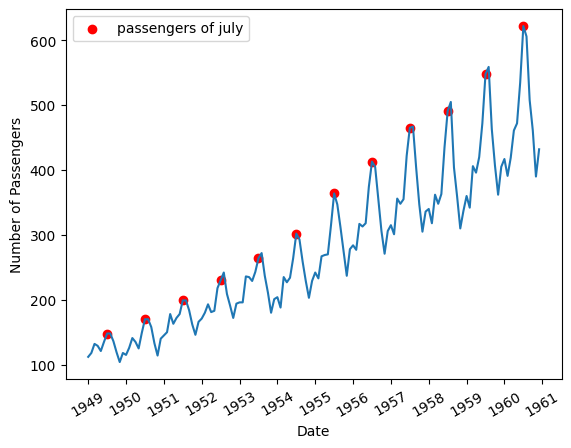

In [4]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots()
july_passengers_index = range(6,144,12)

plt.scatter(july_passengers_index, df.loc[july_passengers_index,'Passengers'], color = 'red', label = 'passengers of july')
plt.plot(df['Passengers'])

ax.set_xlabel('Date')
ax.set_ylabel('Number of Passengers')
plt.xticks(np.arange(0,145,12), np.arange(1949, 1962,1), rotation = 30)
plt.legend()
plt.show()

일반적으로 7월과 8월이 연중 항공 승객 수가 가장 많다는 것을 알 수 있따. 또한 이 데이터는 월별 데이터인데 주기는 연마다 나타나므로, m=12라는 것을 알 수 있다.  
따라서 1961년의 7월을 예측하려면 이전 해의 7월 정보를 유용하게 사용할 수 있을 것이다.  
매개변수 P,D,Q, m을 사용하여 이전 계절 주기로부터 해당 정보를 포착하여  시계열을 예측해보자.  

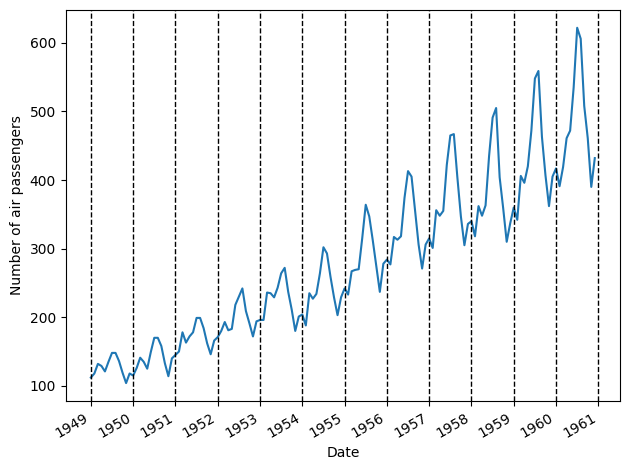

In [5]:
fig, ax = plt.subplots()

ax.plot(df['Month'], df['Passengers'])
for i in np.arange(0,145,12):
  ax.axvline(x = i, linestyle = '--', color = 'black', linewidth = 1)
ax.set_xlabel('Date')
ax.set_ylabel('Number of air passengers')

plt.xticks(np.arange(0, 145, 12), np.arange(1949, 1962, 1))

fig.autofmt_xdate()
plt.tight_layout()

# 시계열에서 계절별 패턴 식별하기

일반적으로 시계열 데이터를 도식화하는 것만으로도 주기적인 패턴을 관찰할 수 있다.  
예를 들어 위의 도식을 살펴보면 월별 항공 승객 수는 매년 6월, 7월, 8월에 많은 승객 수가 기록되고 11월, 12월, 1월에는 승객 수가 줄어드는 등 매년 반복되는 패턴을 쉽게 식별할 수 있다.

statsmodels 라이브러리의 STL함수를 사용하여 분해해보자

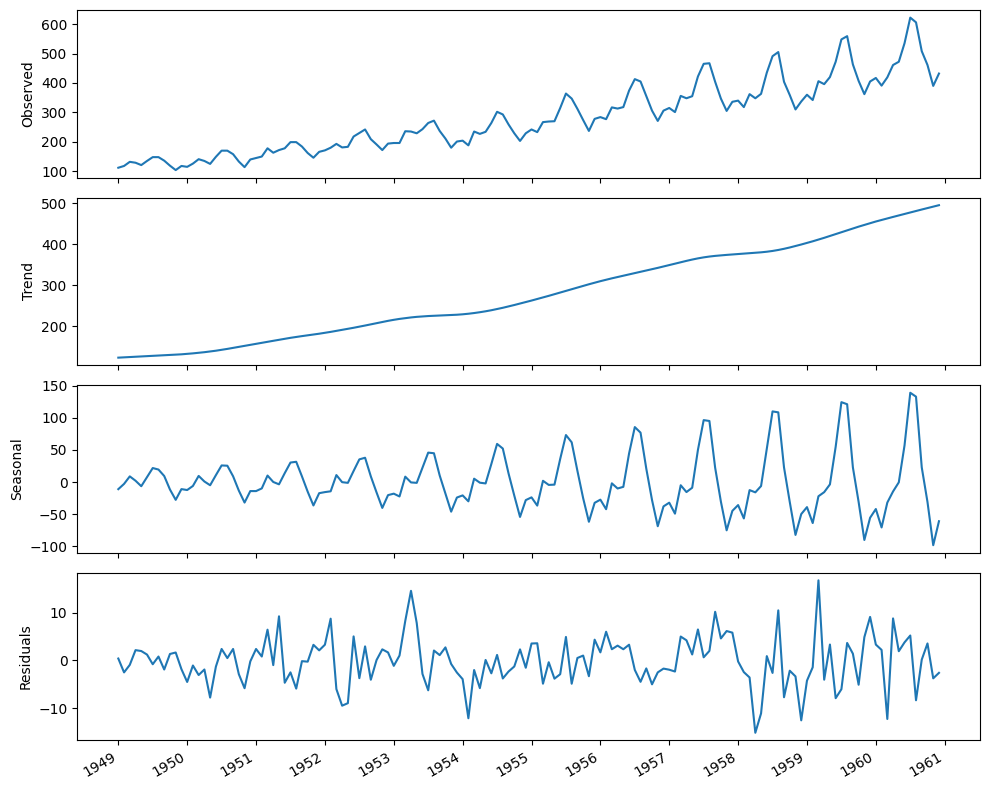

In [6]:
from statsmodels.tsa.seasonal import STL
import numpy as np

decomposition = STL(df['Passengers'], period = 12).fit()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, sharex= True, figsize= (10,8))

ax1.plot(decomposition.observed)
ax1.set_ylabel('Observed')

ax2.plot(decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(decomposition.resid)
ax4.set_ylabel('Residuals')

plt.xticks(np.arange(0,145,12), np.arange(1949, 1962,1))

fig.autofmt_xdate()
plt.tight_layout()

계절적 패턴이 없는 시계열이 있는 상황에서는 분해 절차로 얻은 계절적 구성요소가 0에서 평평한 수평선으로 표시된다. 이를 보여주기 위해 선형 시계열을 시뮬레이션해보자

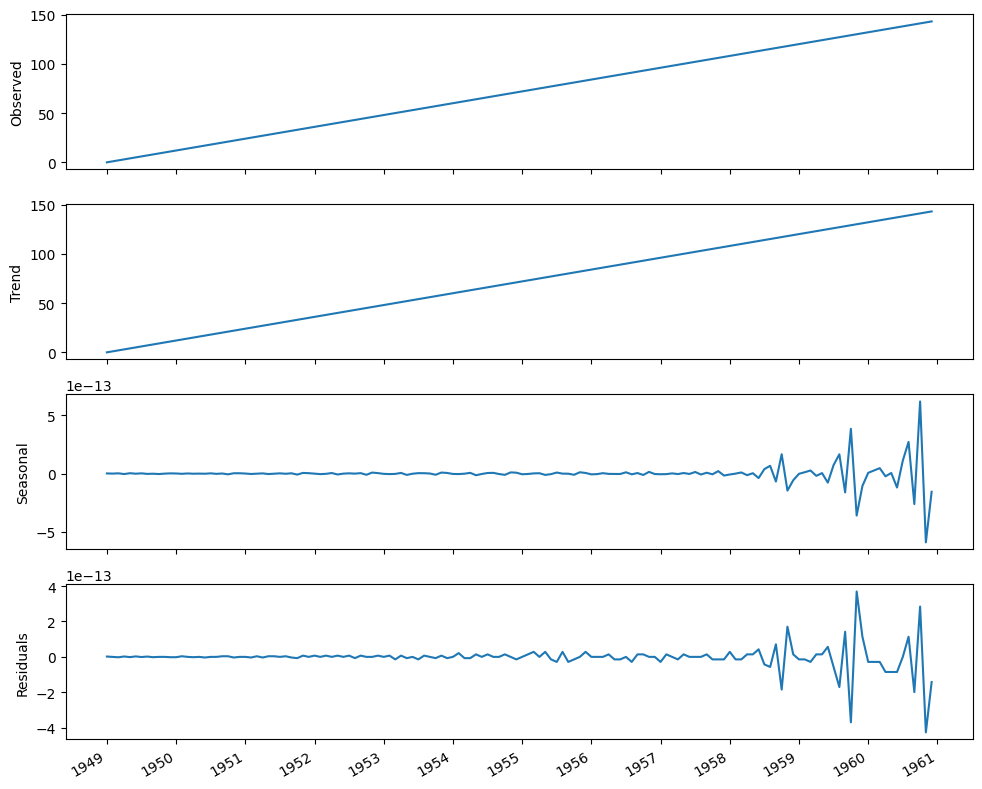

In [7]:
linear_series = np.arange(0, 144, 1)
decomposition = STL(linear_series, period = 12).fit()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, sharex= True, figsize= (10,8))

ax1.plot(decomposition.observed)
ax1.set_ylabel('Observed')

ax2.plot(decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(decomposition.resid)
ax4.set_ylabel('Residuals')

plt.xticks(np.arange(0,145,12), np.arange(1949, 1962,1))

fig.autofmt_xdate()
plt.tight_layout()
plt.show()

# 월간 항공 승객 수 예측하기

1960년의 데이터를 테스트 집합으로 사용해보자

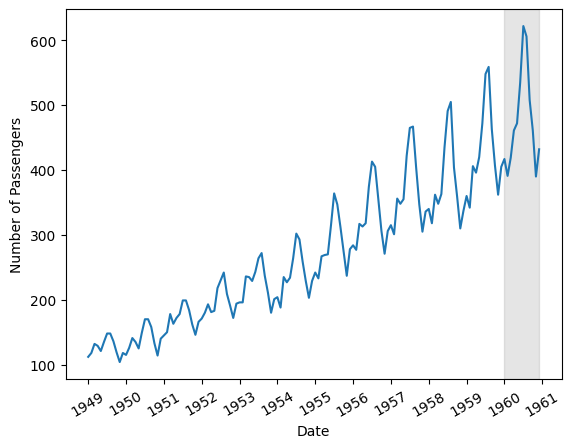

In [8]:
passengers = df['Passengers']
x = passengers[:-12]
test = passengers[-12:]

fig,ax = plt.subplots()
july_passengers_index = range(6,144,12)

plt.plot(df['Passengers'])

ax.set_xlabel('Date')
ax.set_ylabel('Number of Passengers')
ax.axvspan(143-12+1, 143, color = '#808080', alpha = 0.2)
plt.xticks(np.arange(0,145,12), np.arange(1949, 1962,1), rotation = 30)
plt.show()

베이스라인 모델은 단순한 계절적 예측이며, 계절적 요소를 추가하면 더 나은 예측을 얻을 수 있는지 검증하기 위해 ARIMA(p,d,q)와 SARIMA(p,d,q)(P,D,Q)모델을 모두 사용할 것이다.

## ARIMA(p,d,q)모델을 사용하여 예측하기
먼저 ARIMA(p,d,q)모델을 사용하여 데이터 집합을 모델링한다.  


In [9]:
from statsmodels.tsa.stattools import adfuller
ADF_result = adfuller(passengers)
print("ADF Statistic : ", ADF_result[0])
print("p-value : ", ADF_result[1])

ADF Statistic :  0.8153688792060498
p-value :  0.991880243437641


당연하게도 수열은 비정상적이다.
수열을 차분하고 다시 정상성을 테스트해보자

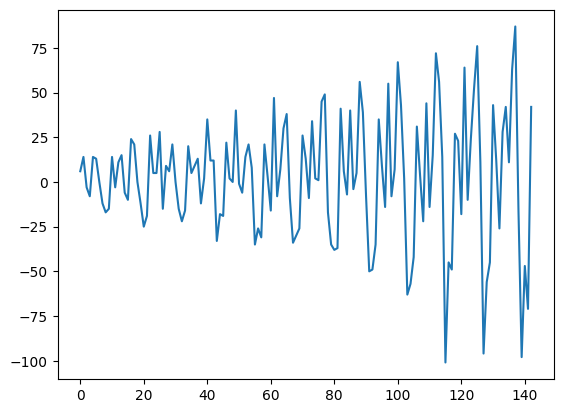

ADF Statistic :  -2.8292668241700047
p-value :  0.05421329028382478


In [10]:
df_diff = np.diff(passengers,n=1)
ADF_result = adfuller(df_diff)
plt.plot(df_diff)
plt.show()
print("ADF Statistic : ", ADF_result[0])
print("p-value : ", ADF_result[1])

이번에도 비정상적임을 알 수 있다.
한 번 더 차분을 진행해보자.  

In [11]:
df_diff2 = np.diff(df_diff, n = 1)
ADF_result = adfuller(df_diff2)
print("ADF Statistic : ", ADF_result[0])
print("p-value : ", ADF_result[1])

ADF Statistic :  -16.384231542468513
p-value :  2.7328918500142026e-29


d = 2임을 알 수 있다.

### ARIMA(p,d,q)조합 피팅하기

In [12]:
from itertools import product
ps = range(0,13,1)
qs = range(0,13,1)
Ps = [0]
Qs = [0]

d = 2
D = 0
s = 12 # 매개변수 s는 m과 동일하며 둘 다 빈도를 나타낸다
ARIMA_order_list = list(product(ps,qs,Ps,Qs))

In [13]:
from typing import Union
from tqdm import tqdm_notebook
from statsmodels.tsa.statespace.sarimax import SARIMAX


def optimize_SARIMA(endog : Union[pd.Series, list], order_list : list,
                    d : int, D : int, s : int) -> pd.DataFrame:
  results = []

  for order in tqdm_notebook(order_list):
    p, q, P, Q = order[0], order[1], order[2], order[3]
    try :
      model = SARIMAX(
          endog,
          order = (p,d,q),
          seasonal_order = (P,D,Q,s),
          simple_differencing = False).fit(disp = False)
    except :
      continue
    aic = model.aic
    results.append([order,aic])

  results_df = pd.DataFrame(results)
  results_df.columns = ['(p,q,P,Q)', 'AIC']

  results_df = results_df.sort_values(by = 'AIC', ascending = True).reset_index(drop = True)
  return results_df

In [ ]:
train = passengers[:-12]

ARIMA_result_df = optimize_SARIMA(train, ARIMA_order_list, d, D, s)


In [16]:
ARIMA_result_df

,"(p,q,P,Q)",AIC
0,"(11, 3, 0, 0)",1016.842652
1,"(11, 4, 0, 0)",1019.034751
2,"(11, 5, 0, 0)",1020.379289
3,"(11, 1, 0, 0)",1021.025922
4,"(12, 0, 0, 0)",1021.169865
...,...,...
164,"(5, 0, 0, 0)",1281.732157
165,"(3, 0, 0, 0)",1300.282335
166,"(2, 0, 0, 0)",1302.913196
167,"(1, 0, 0, 0)",1308.152194


AIC가 가장 낮은 모델은 ARIMA(11,2,3)(0,0,0)_12모델이다.  
이는 ARIMA(11,2,3) 모델과 동일하다.  
보다시피 p=11이므로 AIC가 가장 낮은 모델은 수열의 과거 11개 값을 고려하기 때문에 차수를 0에서 12까지 다양하게 적용해본 것이 모델에 유리했다. 다음 절에서 이것이 시계열에서 계절적 정보를 포착하기에 충분했는지 살펴보고 ARIMA 모델과 SARIMA 모델의 성능을 비교해보자.  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


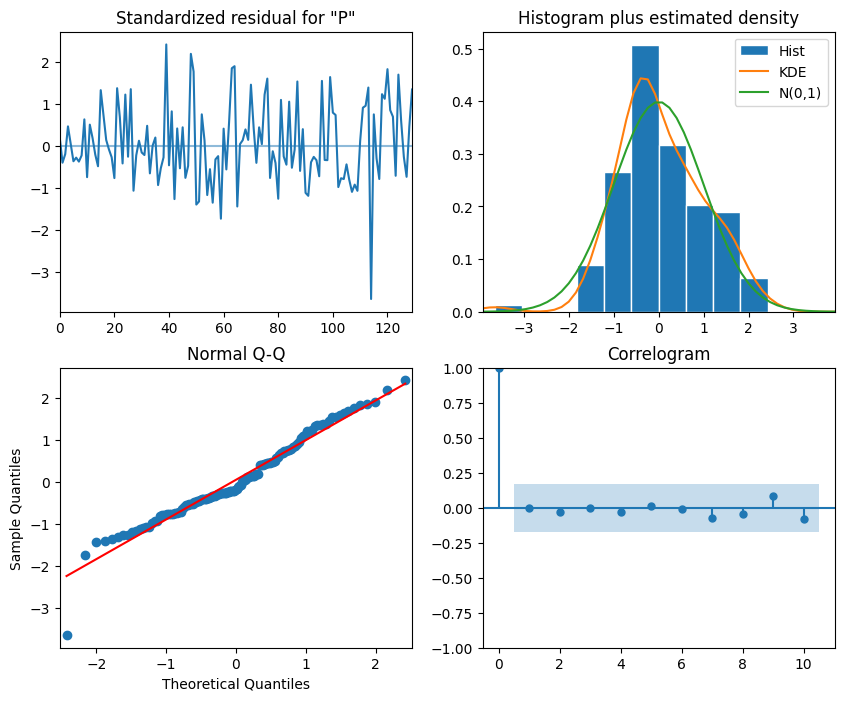

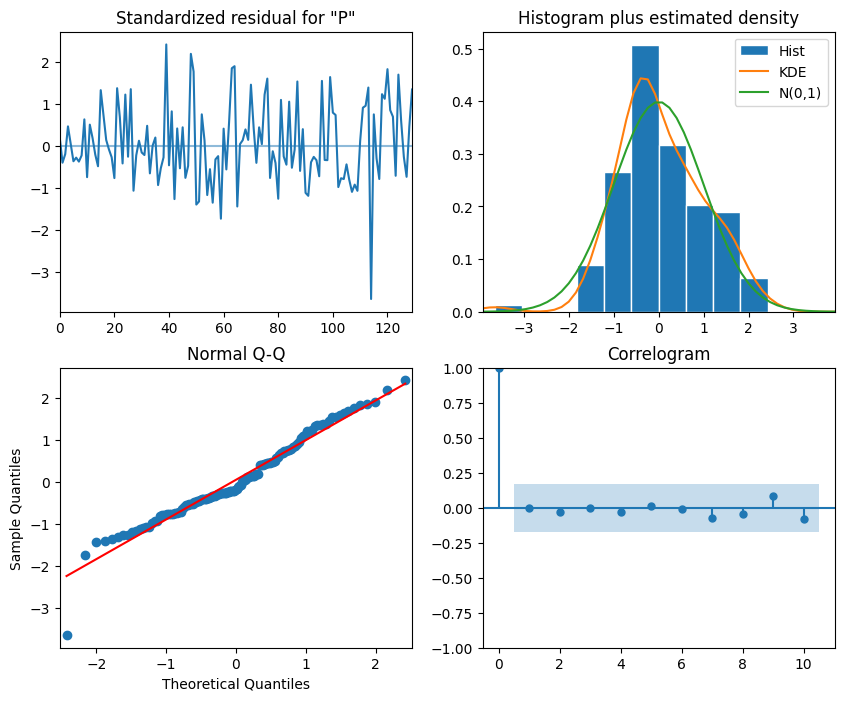

In [17]:
optimum_order_list = (11,2,3)
model = SARIMAX(train, order = optimum_order_list, simple_differencing = False)
model_fit = model.fit(disp = False)
model_fit.plot_diagnostics(figsize = (10,8))

정성적 분석에 따르면 잔차는 백색소음에 가까우므로 오차가 무작위임을 알 수 있다.  

융-박스 테스트를 통해 잔차가 독립적이고 상호 연관성이 없는지 확인해보자.  

In [18]:
from statsmodels.stats.diagnostic import acorr_ljungbox

residuals = model_fit.resid
tr = acorr_ljungbox(residuals, np.arange(1,11,1)) # 처음 10개의 지연에 대해 융-박스 테스트를 수행
print(tr)

      lb_stat  lb_pvalue
1    6.539124   0.010553
2    6.667840   0.035653
3    6.943387   0.073724
4    7.736593   0.101718
5    8.377928   0.136601
6    8.669212   0.193054
7    9.493241   0.219155
8    9.731307   0.284393
9    9.741755   0.371793
10  11.546080   0.316583


처음 두 p-value를 제외하고 모두 0.05보다 크다.  즉, 융-박스 테스트에 따르면 유의도 한계를 0.05로 설정했기 때문에 5%확률로 귀무가설을 기각한다. 그러나 세 번째 값 이후는 모두 0.05보다 크므로 귀무가설을 기각하고 잔차는 지연 3부터 상관관계가 없다는 결론을 내릴 수 있다.  

잔차를 시각적으로 분석하면 백색소음과 비슷하다는 결론을 내릴 수 있지만, 융-박스 테스트에서는 지연 1과 지연 2에서 어느 정도 상관관계가 있다는 것을 알 수 있기 때문에 이것은흥미로운 상황이다.  이는 ARIMA 모델이 데이터의 모든 정보를 포착하지 못하고 있음을 뜻한다.  

In [32]:
test = df.iloc[-12:]

test['naive_seasonal'] = train[-12:].values
test

<ipython-input-32-2ef6a732f7b8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['naive_seasonal'] = train[-12:].values


,Month,Passengers,naive_seasonal
132,1960-01,417,360
133,1960-02,391,342
134,1960-03,419,406
135,1960-04,461,396
136,1960-05,472,420
137,1960-06,535,472
138,1960-07,622,548
139,1960-08,606,559
140,1960-09,508,463
141,1960-10,461,407


In [34]:
ARIMA_pred = model_fit.get_prediction(132,143).predicted_mean
# 132~143번째 예측값을 가져온다

test['ARIMA_pred'] = ARIMA_pred
test

<ipython-input-34-245a98c90224>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ARIMA_pred'] = ARIMA_pred


,Month,Passengers,naive_seasonal,ARIMA_pred
132,1960-01,417,360,422.423451
133,1960-02,391,342,410.712068
134,1960-03,419,406,461.932587
135,1960-04,461,396,457.887529
136,1960-05,472,420,481.783456
137,1960-06,535,472,531.225222
138,1960-07,622,548,606.187559
139,1960-08,606,559,615.417675
140,1960-09,508,463,525.453898
141,1960-10,461,407,467.066240


이제 SARIMA 모델을 사용해본 뒤 두 모델의 성능을 비교하여 계절별 시계열에 적용했을 때 SARIMA 모델이 실제로 ARIMA 모델보다 더 나은 성능을 보이는지 확인해보자

## SARIMA(p,d,q)(P,D,Q)_m모델을 사용하여 예측하기

In [37]:
df_diff = np.diff(passengers, n =1)

ADF_result = adfuller(df_diff)
print("ADF Statistic : ", ADF_result[0])
print("p-value : ", ADF_result[1])

ADF Statistic :  -2.8292668241700047
p-value :  0.05421329028382478


1차 차분을 적용해도 시계열이 정상적 상태가 아니다.  
계절적 차분을 적용하고 정상성을 테스트해보자.

In [38]:
df_diff_seasonal_diff = np.diff(df_diff, n = 12)
ADF_result = adfuller(df_diff_seasonal_diff)
print("ADF Statistic : ", ADF_result[0])
print("p-value : ", ADF_result[1])

ADF Statistic :  -17.62486236026156
p-value :  3.823046855601547e-30


한 번의 차분과 한 번의 계절적 차분 이후 수열이 정상적 상태가 된 것으로 간주할 수 있다.  


In [39]:
ps = range(0,4,1)
qs = range(0,4,1)
Ps = range(0,4,1)
Qs = range(0,4,1)

d = 1
D = 1
s = 12 # 매개변수 s는 m과 동일하며 둘 다 빈도를 나타낸다
SARIMA_order_list = list(product(ps,qs,Ps,Qs))

In [ ]:
train = passengers[:-12]
SARIMA_result_df = optimize_SARIMA(train, SARIMA_order_list, d, D, s)
SARIMA_result_df

In [42]:
SARIMA_result_df

,"(p,q,P,Q)",AIC
0,"(2, 1, 1, 2)",892.240189
1,"(2, 1, 1, 3)",894.110325
2,"(1, 0, 1, 2)",894.285656
3,"(0, 1, 1, 2)",894.991643
4,"(1, 0, 2, 1)",895.092629
...,...,...
251,"(0, 0, 2, 0)",906.940147
252,"(3, 2, 0, 3)",907.181875
253,"(0, 0, 3, 2)",907.603099
254,"(0, 0, 3, 0)",908.742583


SARIMA(2,1,1)(1,1,2)_12모델이 892.24로 AIC가 가장 낮다는 것을 알 수 있다.  
이 모델을 훈련 집합에 다시 피팅하고 잔차 분석을 수행해 보자.

잔차에 대한 진단을 도식화해보자

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


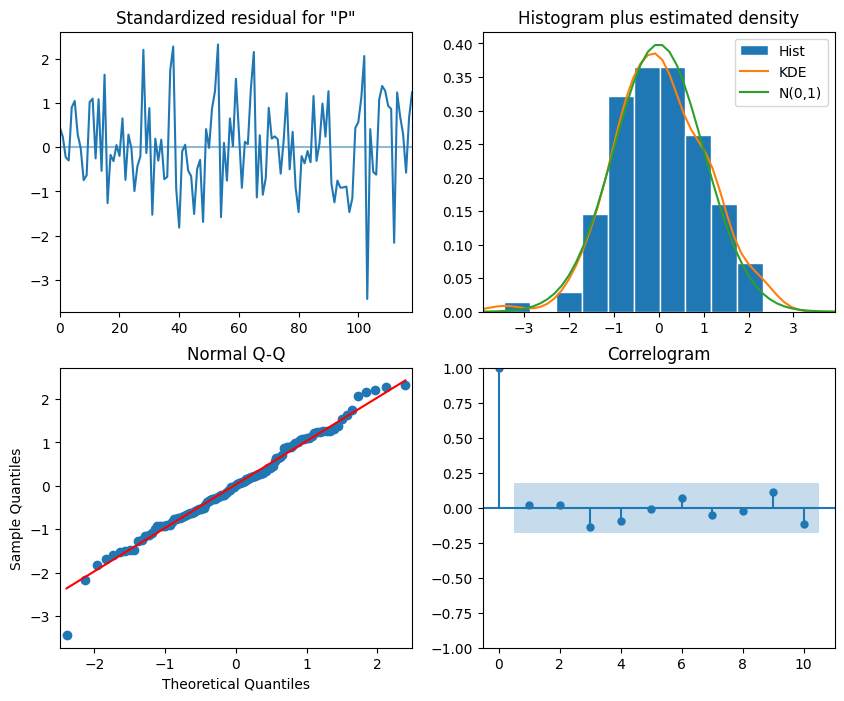

In [43]:
optimum_order_list = (2,1,1)
optimum_seasonal_order_list = (1,1,2,12)
SARIMA_model = SARIMAX(train,
                       order = optimum_order_list,
                       seasonal_order = optimum_seasonal_order_list,
                       simple_differencing = False)
SARIMA_model_fit = SARIMA_model.fit(disp = False)

SARIMA_model_fit.plot_diagnostics(figsize=(10,8));

정성적 분석에 따르면 잔차는 백색소음에 가까우므로 오차가 무작위임을 알 수 있다.  

마지막으로 융-박스 테스트를 진행해보자.

In [44]:
residuals = SARIMA_model_fit.resid
tr = acorr_ljungbox(residuals, np.arange(1,11,1)) # 처음 10개의 지연에 대해 융-박스 테스트를 수행
print(tr)

     lb_stat  lb_pvalue
1   0.004663   0.945557
2   0.744726   0.689104
3   1.019752   0.796473
4   1.226798   0.873667
5   1.437233   0.920197
6   1.711221   0.944252
7   2.306318   0.940962
8   2.720695   0.950645
9   2.737284   0.973807
10  4.976578   0.892737


p-value가 모두 0.05보다 크므로, 잔차끼리의 상관관계가 없다고 볼 수 있다.

# 각 예측 방법의 성능 비교하기

In [45]:
SARIMAX_pred = SARIMA_model_fit.get_prediction(132, 143).predicted_mean

In [47]:
test['SARIMA_pred'] = SARIMAX_pred
test

<ipython-input-47-27ee15a26409>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['SARIMA_pred'] = SARIMAX_pred


,Month,Passengers,naive_seasonal,ARIMA_pred,SARIMA_pred
132,1960-01,417,360,422.423451,418.524884
133,1960-02,391,342,410.712068,399.567753
134,1960-03,419,406,461.932587,461.302182
135,1960-04,461,396,457.887529,451.428644
136,1960-05,472,420,481.783456,473.719243
137,1960-06,535,472,531.225222,538.771197
138,1960-07,622,548,606.187559,612.413497
139,1960-08,606,559,615.417675,624.570118
140,1960-09,508,463,525.453898,520.148531
141,1960-10,461,407,467.066240,462.829156


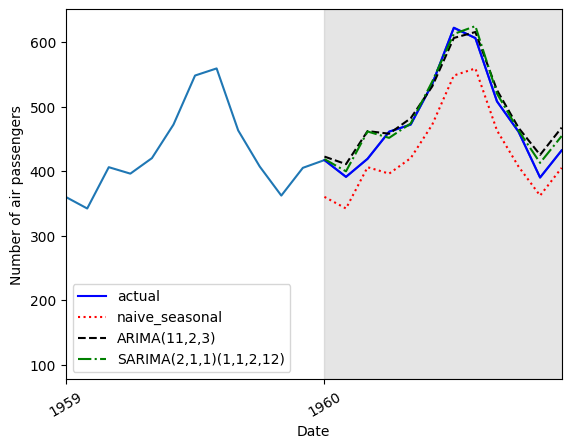

In [51]:
fig,ax = plt.subplots()

plt.plot(passengers)
plt.plot(test['Passengers'], 'b-', label = 'actual')
plt.plot(test['naive_seasonal'], 'r:', label = 'naive_seasonal')
plt.plot(test['ARIMA_pred'], 'k--', label = 'ARIMA(11,2,3)')
plt.plot(test['SARIMA_pred'], 'g-.', label = 'SARIMA(2,1,1)(1,1,2,12)')

ax.set_xlabel('Date')
ax.set_ylabel('Number of air passengers')
ax.axvspan(132, 143, color = '#808080', alpha = 0.2)
ax.legend()
plt.xticks(np.arange(0,145,12), np.arange(1949, 1962,1), rotation = 30)
ax.set_xlim(120,143) # 테스트 집합을 확대한다
plt.show()

각 모델의 MAPE를 측정하여 막대형 차트에 표시해보자.

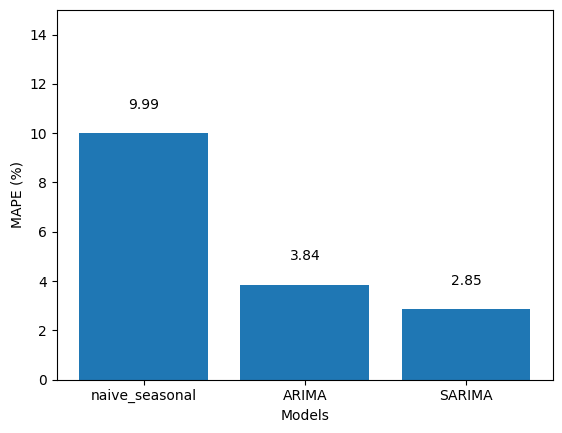

In [52]:
# from sklearn.metrics import mean_absolute_erro

def mape(y_true, y_pred):
  return np.mean(np.abs( (y_true - y_pred) / y_true)) * 100

mape_naive_seasonal = mape(test['Passengers'], test['naive_seasonal'])
mape_ARIMA = mape(test['Passengers'], test['ARIMA_pred'])
mape_SARIMA = mape(test['Passengers'], test['SARIMA_pred'])

model_nm = ['naive_seasonal', 'ARIMA', 'SARIMA']
maes = [mape_naive_seasonal, mape_ARIMA, mape_SARIMA]


fig, ax = plt.subplots()
plt.bar(model_nm, maes)
ax.set_xlabel('Models')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0,15)

for index, height in enumerate(maes):
  plt.text(x = index, y = height+1, s = str(round(height,2)), ha = 'center')

plt.show()

베이스라인 모델이 9.99%의 MAPE를 달성했고, ARIMA모델은 3.85%의 MAPE, SARIMA 모델은 2.85%의 MAPE를 기록했다.  